In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

#### Define the model

In [2]:
class SLM(torch.nn.Module):

    def __init__(
        self,
        n_nodes: int,
        g: float,
        f: float,
        h: float,
        eta: float,
        n_inputs: int,
        n_outputs: int,
    ):
        super().__init__()

        # Network parameters
        self.n_nodes = n_nodes

        # Node parameters
        self.a = torch.nn.Parameter(-5 * torch.rand(n_nodes))
        self.g = g
        self.eta = eta * torch.sqrt(torch.tensor(h))
        if isinstance(f, (int, float)):
            self.f = f * torch.ones(n_nodes)
        else:
            self.f = 60 * torch.rand(n_nodes) + 20
        self.f = torch.nn.Parameter(2 * torch.pi * self.f)

        # Simulation parameters
        self.h = h

        # Recurrent connections
        self.W_rec = torch.nn.Parameter(torch.rand((n_nodes, n_nodes)) * 0.1)
        # Input to hidden layer
        self.W_input = torch.nn.Linear(n_inputs, n_nodes)
        # Output layer
        self.W_output = torch.nn.Linear(n_nodes, n_outputs)

    def __ode(self, z: torch.Tensor, a: torch.Tensor, w: torch.Tensor):
        return z * (a + 1j * w - torch.abs(z)**2)

    def loop(self, z_t: torch.Tensor, I_ext: torch.Tensor):

        z_t = (
            z_t
            + self.h * self.__ode(z_t, self.a, self.f)
            + self.h * self.g * (self.W_rec * (z_t[:, None] - z_t[..., None])).sum(-1)
            + self.h * self.W_input(I_ext)
            + self.eta * torch.randn(z_t.shape)
            + self.eta * 1j * torch.randn(z_t.shape)
        )

        return z_t

    def forward(self, n_trials: int, n_times: int, input: torch.Tensor):

        rec_z_t = torch.zeros(n_trials, n_times, self.n_nodes, dtype=torch.complex64)

        z_t = self.h * torch.randn(n_trials, self.n_nodes) + 1j * self.h * torch.randn(
            n_trials, self.n_nodes
        )

        z_t = torch.autograd.Variable(z_t)

        for t in range(n_times):
            z_t = self.loop(z_t, input[t])
            rec_z_t[:, t, :] = z_t

        output = {}
        output["rec"] = rec_z_t
        output["output"] = self.W_output(z_t.real)

        return output

#### Evaluation function

In [3]:
# run inference on test set
def evaluate_model(data_loader, epoch=None, batch=None):
    model.eval()
    correct = 0
    test_loss = 0
    with torch.no_grad():
        # loop over batches in data loader
        for i, (images, labels) in enumerate(data_loader):
            # reshape batch
            images = images.reshape(batch_size_test, 1, 50 * 50)
            images = images.permute(2, 0, 1)
            n_times, n_trials, _ = images.shape
            # run model inference - record true returns dynamics
            output = model.forward(n_trials, n_times, images)
            prediction = output["output"]
            # compute loss + number of correct predictions
            test_loss += loss(prediction, labels).item()
            pred_label = prediction.data.max(1, keepdim=True)[1]
            correct += pred_label.eq(labels.data.view_as(pred_label)).sum()
    # compute loss and accuracy
    test_loss /= len(data_loader)
    accuracy = 100.0 * correct / len(data_loader.dataset)

    return accuracy.item()

#### Simulate example    

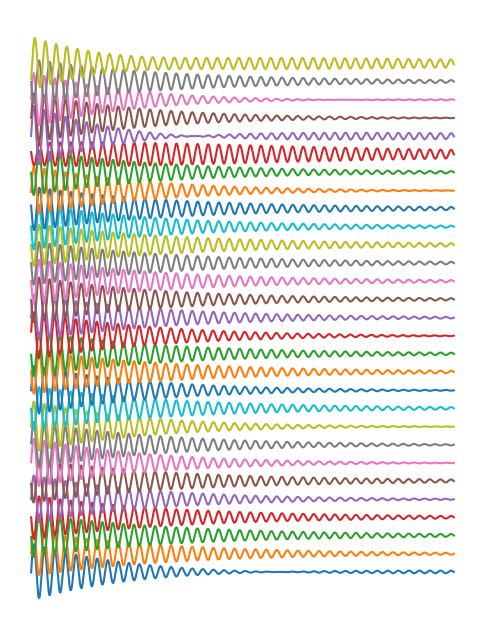

In [4]:
T = 1
h = 1e-4
n_trials = 10
n_times = int(T // h)
n_nodes = 29
npixels = 50

input = torch.zeros((n_times, n_trials, 1))
model = SLM(n_nodes, 1, 40, h, 0, 1, 1)
model.a = torch.nn.Parameter(torch.ones(n_nodes) * -5)
out = model.forward(n_trials, n_times, input)

out = out["rec"].cpu().detach().numpy()

out = (out - out.mean(1)[:, None, :]) / out.std(1)[:, None, :]

plt.figure(figsize=(6, 8))
for i in range(29):
    plt.plot(out[0, :, i].real + (i * 2))
plt.axis("off");

In [5]:
def generate_input(ti, tf, h, label, sigma=0.1):
    assert label in [0, 1]
    n_times = int(T // h)
    times = torch.linspace(ti, tf, n_times)
    I = torch.zeros(n_times)
    # Choose stimuli
    I_0, I_1 = np.random.choice([1, 2, 3, 4, 5], 2, replace=False)

    I[torch.logical_and(times >= 0, times <= 0.4)] = I_0

    if label == 0:
        I[torch.logical_and(times >= 1.4, times <= 1.8)] = I_1
    else:
        I[torch.logical_and(times >= 1.4, times <= 1.8)] = I_0
    # Add noise
    I = I + torch.randn(n_times) * sigma
    return I, label


class InputDataset(Dataset):
    def __init__(self, ti, tf, h, size, sigma=0.1):
        self.ti = ti
        self.tf = tf
        self.h = h
        self.size = size
        self.sigma = sigma

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        label = np.random.choice([0, 1])
        I, label = generate_input(self.ti, self.tf, self.h, label, self.sigma)
        return I.float(), torch.tensor(label, dtype=torch.long)

In [6]:
tf = 3
ti = -2
T = (tf - ti)
h = 1e-4
n_times = int(tf // h)
times = np.linspace(-2, 3, n_times)
n_nodes = 29
size=10000
sigma = 1e-2

train_set = InputDataset(ti, tf, h, size, sigma)
test_set = InputDataset(ti, tf, h, size, sigma)

In [7]:
from torch.utils.data import DataLoader

# batch size of the test set
batch_size_train = 100
batch_size_test = 1000
size_validation = 1000


train_set, valid_set = torch.utils.data.random_split(
    train_set, [len(train_set) - size_validation, size_validation]
)

# data loaders
train_loader = torch.utils.data.DataLoader(
    dataset=train_set, batch_size=batch_size_train, shuffle=True
)
valid_loader = torch.utils.data.DataLoader(
    dataset=valid_set, batch_size=batch_size_test, shuffle=False
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_set, batch_size=batch_size_test, shuffle=False
)

model = SLM(n_nodes, 1, None, h, 1e-3, 1, 2)

# bce loss and optimizer for training
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)

In [8]:
# Use MNIST as input
dim_input = 1

# 10 MNIST classes
dim_output = 2

# batch size of the test set
batch_size_train = 100
batch_size_test = 1000

# load dataset
size_validation = 1000  # size of validation dataset
train_set = torchvision.datasets.MNIST(
    root="data",
    train=True,
    transform=torchvision.transforms.Compose(
        [torchvision.transforms.Resize(npixels), torchvision.transforms.ToTensor()]
    ),
    download=True,
)
test_set = torchvision.datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.Compose(
        [torchvision.transforms.Resize(npixels), torchvision.transforms.ToTensor()]
    ),
)
train_set, valid_set = torch.utils.data.random_split(
    train_set, [len(train_set) - size_validation, size_validation]
)

# data loaders
train_loader = torch.utils.data.DataLoader(
    dataset=train_set, batch_size=batch_size_train, shuffle=True
)
valid_loader = torch.utils.data.DataLoader(
    dataset=valid_set, batch_size=batch_size_test, shuffle=False
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_set, batch_size=batch_size_test, shuffle=False
)

model = SLM(n_nodes, 1, None, h, 1e-4, 1, 10)

# bce loss and optimizer for training
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)

In [9]:
epochs = 1
batch_size = 50
# training loop
best_eval = 0.0
for epoch in tqdm(range(epochs), total=epochs):
    tqdm.write(f"epoch {epoch}")
    # loop over batches for one epoch
    for batch, (images, labels) in tqdm(
        enumerate(train_loader), total=len(train_loader)
    ):
        # set model into train mode
        model.train()

        # reshape samples
        images = images.reshape(batch_size_train, 1, -1)

        # dimensions: time x batch x 1
        images = images.permute(2, 0, 1)
        n_times, n_trials, _ = images.shape

        # zero gradients
        optimizer.zero_grad()

        # predict
        output = model.forward(n_trials, n_times, images)
        prediction = output["output"]

        # compute loss
        train_loss = loss(prediction, labels)

        # compute gradients
        train_loss.backward()

        # update parameters
        optimizer.step()

        if batch % 100 == 0:
            test_acc = evaluate_model(test_loader, epoch, batch)
            tqdm.write(f"epoch {epoch} batch {batch}: test acc {test_acc:.2f}")

  0%|                                                     | 0/1 [00:00<?, ?it/s]

epoch 0



                                                                                
  0%|                                                     | 0/1 [00:18<?, ?it/s]
%|                                                   | 0/590 [00:18<?, ?it/s]
%|                                         | 1/590 [00:18<3:04:36, 18.81s/it]

epoch 0 batch 0: test acc 10.10



%|▏                                        | 2/590 [00:20<1:25:14,  8.70s/it]
%|▏                                          | 3/590 [00:21<53:03,  5.42s/it]
%|▎                                          | 4/590 [00:23<37:43,  3.86s/it]
%|▎                                          | 5/590 [00:25<29:49,  3.06s/it]
%|▍                                          | 6/590 [00:26<25:47,  2.65s/it]
%|▌                                          | 7/590 [00:28<23:15,  2.39s/it]
%|▌                                          | 8/590 [00:30<21:07,  2.18s/it]
%|▋                                          | 9/590 [00:32<19:57,  2.06s/it]
%|▋                                         | 10/590 [00:33<18:30,  1.92s/it]
%|▊                                         | 11/590 [00:35<17:24,  1.80s/it]
%|▊                                         | 12/590 [00:36<16:38,  1.73s/it]
%|▉                                         | 13/590 [00:38<16:05,  1.67s/it]
%|▉                                         | 14/590 [00:40<15:

epoch 0 batch 100: test acc 29.44



%|███████                                  | 102/590 [03:25<46:10,  5.68s/it]
%|███████▏                                 | 103/590 [03:27<36:42,  4.52s/it]
%|███████▏                                 | 104/590 [03:29<30:30,  3.77s/it]
%|███████▎                                 | 105/590 [03:31<25:36,  3.17s/it]
%|███████▎                                 | 106/590 [03:33<22:01,  2.73s/it]
%|███████▍                                 | 107/590 [03:34<19:37,  2.44s/it]
%|███████▌                                 | 108/590 [03:36<17:57,  2.24s/it]
%|███████▌                                 | 109/590 [03:38<16:59,  2.12s/it]
%|███████▋                                 | 110/590 [03:40<16:28,  2.06s/it]
%|███████▋                                 | 111/590 [03:42<16:06,  2.02s/it]
%|███████▊                                 | 112/590 [03:44<16:32,  2.08s/it]
%|███████▊                                 | 113/590 [03:46<16:03,  2.02s/it]
%|███████▉                                 | 114/590 [03:48<15:

epoch 0 batch 200: test acc 37.19



%|██████████████                           | 202/590 [06:29<33:24,  5.17s/it]
%|██████████████                           | 203/590 [06:31<27:08,  4.21s/it]
%|██████████████▏                          | 204/590 [06:33<23:01,  3.58s/it]
%|██████████████▏                          | 205/590 [06:35<19:29,  3.04s/it]
%|██████████████▎                          | 206/590 [06:37<17:32,  2.74s/it]
%|██████████████▍                          | 207/590 [06:39<15:58,  2.50s/it]
%|██████████████▍                          | 208/590 [06:41<14:31,  2.28s/it]
%|██████████████▌                          | 209/590 [06:42<13:07,  2.07s/it]
%|██████████████▌                          | 210/590 [06:44<12:19,  1.95s/it]
%|██████████████▋                          | 211/590 [06:46<11:41,  1.85s/it]
%|██████████████▋                          | 212/590 [06:47<11:03,  1.76s/it]
%|██████████████▊                          | 213/590 [06:49<10:37,  1.69s/it]
%|██████████████▊                          | 214/590 [06:50<10:

epoch 0 batch 300: test acc 37.93



%|████████████████████▉                    | 302/590 [09:29<25:06,  5.23s/it]
%|█████████████████████                    | 303/590 [09:31<19:59,  4.18s/it]
%|█████████████████████▏                   | 304/590 [09:33<16:11,  3.40s/it]
%|█████████████████████▏                   | 305/590 [09:34<13:32,  2.85s/it]
%|█████████████████████▎                   | 306/590 [09:36<11:46,  2.49s/it]
%|█████████████████████▎                   | 307/590 [09:37<10:25,  2.21s/it]
%|█████████████████████▍                   | 308/590 [09:39<09:28,  2.02s/it]
%|█████████████████████▍                   | 309/590 [09:41<08:48,  1.88s/it]
%|█████████████████████▌                   | 310/590 [09:42<08:16,  1.77s/it]
%|█████████████████████▌                   | 311/590 [09:44<07:57,  1.71s/it]
%|█████████████████████▋                   | 312/590 [09:45<07:45,  1.67s/it]
%|█████████████████████▊                   | 313/590 [09:47<07:31,  1.63s/it]
%|█████████████████████▊                   | 314/590 [09:49<07:

epoch 0 batch 400: test acc 35.74



%|███████████████████████████▉             | 402/590 [12:30<17:22,  5.55s/it]
%|████████████████████████████             | 403/590 [12:31<13:32,  4.34s/it]
%|████████████████████████████             | 404/590 [12:33<10:52,  3.51s/it]
%|████████████████████████████▏            | 405/590 [12:34<09:03,  2.94s/it]
%|████████████████████████████▏            | 406/590 [12:36<07:45,  2.53s/it]
%|████████████████████████████▎            | 407/590 [12:38<07:00,  2.30s/it]
%|████████████████████████████▎            | 408/590 [12:39<06:24,  2.11s/it]
%|████████████████████████████▍            | 409/590 [12:41<06:11,  2.05s/it]
%|████████████████████████████▍            | 410/590 [12:43<05:52,  1.96s/it]
%|████████████████████████████▌            | 411/590 [12:45<05:51,  1.96s/it]
%|████████████████████████████▋            | 412/590 [12:47<05:43,  1.93s/it]
%|████████████████████████████▋            | 413/590 [12:49<05:34,  1.89s/it]
%|████████████████████████████▊            | 414/590 [12:50<05:

epoch 0 batch 500: test acc 39.44



%|██████████████████████████████████▉      | 502/590 [15:37<08:09,  5.56s/it]
%|██████████████████████████████████▉      | 503/590 [15:38<06:20,  4.37s/it]
%|███████████████████████████████████      | 504/590 [15:40<05:07,  3.58s/it]
%|███████████████████████████████████      | 505/590 [15:42<04:19,  3.05s/it]
%|███████████████████████████████████▏     | 506/590 [15:44<03:45,  2.68s/it]
%|███████████████████████████████████▏     | 507/590 [15:46<03:20,  2.41s/it]
%|███████████████████████████████████▎     | 508/590 [15:47<03:04,  2.25s/it]
%|███████████████████████████████████▎     | 509/590 [15:49<02:53,  2.14s/it]
%|███████████████████████████████████▍     | 510/590 [15:51<02:47,  2.09s/it]
%|███████████████████████████████████▌     | 511/590 [15:53<02:37,  1.99s/it]
%|███████████████████████████████████▌     | 512/590 [15:55<02:32,  1.96s/it]
%|███████████████████████████████████▋     | 513/590 [15:57<02:41,  2.10s/it]
%|███████████████████████████████████▋     | 514/590 [15:59<02:

In [10]:
torch.sort(model.f / (2 * torch.pi))

torch.return_types.sort(
values=tensor([19.8863, 20.3341, 22.5868, 24.4869, 26.2433, 27.5657, 30.5005, 30.7225,
        31.6209, 36.9726, 39.3220, 39.8747, 40.5752, 40.8054, 41.0308, 44.5882,
        49.5570, 51.3988, 55.4878, 55.8269, 56.9716, 60.1162, 61.7888, 62.5408,
        64.5294, 66.6793, 71.4272, 72.5493, 75.1655], grad_fn=<SortBackward0>),
indices=tensor([22, 19, 21,  3, 20, 23, 27,  6,  4, 10, 11, 18, 12,  9,  0, 15, 24,  8,
         2, 14, 17, 28, 26,  1, 13, 16,  7, 25,  5]))

In [11]:
model.a

Parameter containing:
tensor([-4.3675, -2.1807, -0.3834, -1.2385, -0.6619, -0.2234, -1.3202, -0.5710,
        -0.4640, -4.1640, -1.6624, -1.5303, -1.9141, -3.4880, -2.7938, -2.7821,
        -1.8052,  0.1452, -2.8384, -0.7102, -2.6874, -3.6066,  0.3370,  0.0895,
        -0.2099, -3.5592, -3.6210,  0.4679, -0.6962], requires_grad=True)

In [12]:
out.shape

(10, 9999, 29)

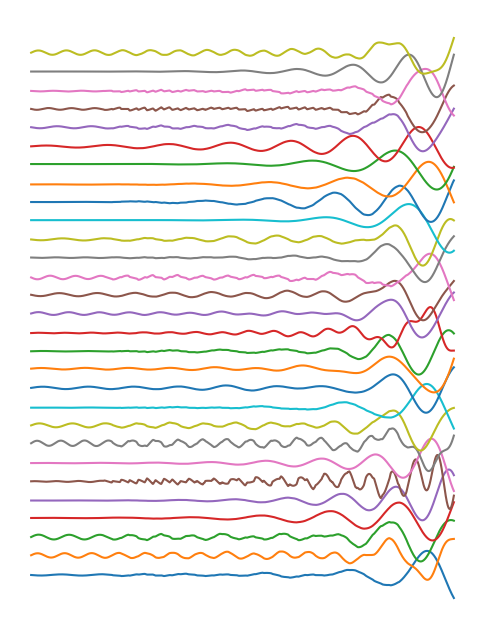

In [13]:
plt.figure(figsize=(6, 8))
out = output["rec"].cpu().detach().numpy()
out = (out - out.mean(1)[:, None, :]) / out.std(1)[:, None, :]

for i in range(29):
    plt.plot(out[4, :, i].real + (i * 2))
plt.axis("off");

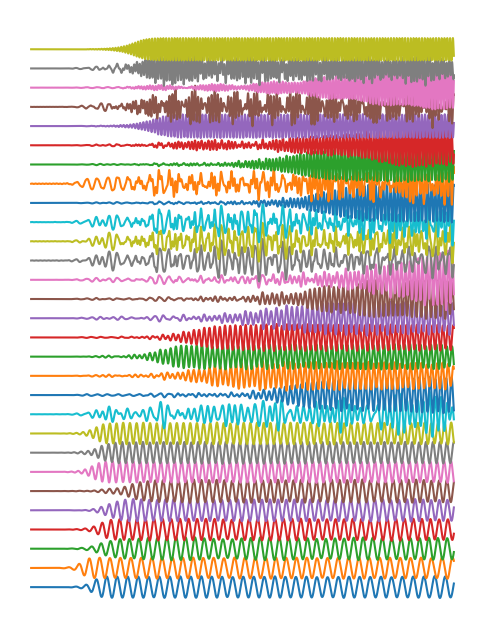

In [14]:
T = 2
h = 1e-4
n_trials = 10
n_times = int(T // h)
n_nodes = 29

input = torch.zeros((n_times, n_trials, 1))

out = model.forward(n_trials, n_times, input)

out = out["rec"].cpu().detach().numpy()
out = out[..., torch.argsort(model.f)]

out = (out - out.mean(1)[:, None, :]) / out.std(1)[:, None, :]
plt.figure(figsize=(6, 8))
for i in range(29):
    plt.plot(out[0, :, i].real + (i * 2))
plt.axis("off");

In [15]:
torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

device(type='cpu')